In [587]:
import multiprocessing as mp

import string
import pickle
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix

In [588]:
#%%timeit: 2min 22s ± 302 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# wv_from_text = KeyedVectors.load_word2vec_format("numberbatch-en-19.08.txt")

# %%timeit: 723 ms ± 8.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
numberbatch = pickle.load(open("numberbatch-en-19.08-en.pickle", 'rb'))

In [589]:
len(numberbatch.vocab)

516782

In [590]:
! ls datasets/silknow

en_material_post2.csv	  zeste_material_en_post.csv
en_technique_post2.csv	  zeste_material_es_post.csv
es_material_post2.csv	  zeste_technique_en_post.csv
es_technique_post2.csv	  zeste_technique_es_post.csv
es_visual_item_post2.csv  zeste_visual_item_es_post.csv


In [591]:
ds_materials = pd.read_csv('datasets/silknow/zeste_material_en_post.csv').rename(columns={'material':'label'})
ds_materials.label = ds_materials.label.str.lower()
ds_materials.head()

,text,label
0,"Collar, embroidered silk satin for man's robe,...",http://data.silknow.org/vocabulary/627
1,Collar of embroidered silk satin for man's rob...,http://data.silknow.org/vocabulary/627
2,The complete object would have been intended f...,http://data.silknow.org/vocabulary/627
3,"Pair of ""mashru"" trousers",http://data.silknow.org/vocabulary/627
4,"Pair of ""mashru"" trousers, ikat,Varanasi, c.1867",http://data.silknow.org/vocabulary/627


In [592]:
ds_materials.label.value_counts()

http://data.silknow.org/vocabulary/628    557
http://data.silknow.org/vocabulary/627    344
Name: label, dtype: int64

In [593]:
len(ds_materials)

901

In [594]:
def get_word_neighborhood(word, depth=2, allowed_rels=['isa', 'relatedto', 'synonym'], keep='top20000'):
    neighborhood = pickle.load(open('/data/zeste_cache/neighborhoods/'+word+'.pickle', 'rb'))
    neighborhood_words = list(neighborhood.keys())
    
    if allowed_rels != 'all':
        for n in neighborhood_words:
            if all(rel not in neighborhood[n]['rels'] for rel in allowed_rels):
                del neighborhood[n]
                continue

    to_visit_next = list(neighborhood.keys())
    
    while depth > 1:
        
        additions = []
        while len(to_visit_next) > 0:
            w = to_visit_next.pop()
            nn = get_word_neighborhood(w, depth=1, allowed_rels=allowed_rels)
            for ww in nn:
                if ww in neighborhood:
                    neighborhood[ww]['from'].append(w)
                    neighborhood[ww]['rels'].extend(['<>'] + nn[ww]['rels'])
                else:
                    neighborhood[ww] = {}
                    neighborhood[ww]['from'] = [w]
                    neighborhood[ww]['rels'] = nn[ww]['rels']
                    if word in numberbatch and ww in numberbatch:
                        neighborhood[ww]['sim'] = numberbatch.similarity(word, ww)
                    else:
                        neighborhood[ww]['sim'] = 0.0
                    additions.append(ww)
        to_visit_next = additions
        depth -= 1
    
    if keep.startswith('top'):
        k = int(keep.split('top')[1])
        all_scores = [neighborhood[kw]['sim'] for kw in neighborhood]
        all_words = list(neighborhood.keys())
        if k < len(all_scores):
            lowest_top = sorted(all_scores, reverse=True)[k]
            for kw in all_words:
                if neighborhood[kw]['sim'] <= lowest_top:
                    del neighborhood[kw]
    
    return neighborhood

In [595]:
def preprocess(doc):
    doc = ''.join(c for c in doc if c not in string.punctuation or c == ' ').lower()
    doc_tokens = doc.split(' ')
    doc_tokens = [w.lower() for w in doc_tokens]
    doc_tokens = [w for w in doc_tokens if w not in stopwords.words('english')]
    doc_tokens = [w.replace('"', '').replace('?', '') for w in doc_tokens]
    doc_tokens = [w.replace('-', '_') for w in doc_tokens if w != '']

    return doc_tokens

In [596]:
def get_words_neighborhood(words, depth=2, allowed_rels=['isa', 'relatedto', 'synonym'], keep='top20000'):
    words = words.split(';')
    ns = []
    
    for word in words:
        ns.append(get_word_neighborhood(word, depth=depth, allowed_rels=allowed_rels, keep=keep))
    neighborhood = ns[0].copy()
    
    for w, nn in zip(words[1:], ns[1:]):
        for ww in nn:
            if ww in neighborhood:
                neighborhood[ww]['from'].append(w)
                neighborhood[ww]['rels'].extend(['<>'] + nn[ww]['rels'])
                neighborhood[ww]['sim'] = max(neighborhood[ww]['sim'], nn[ww]['sim'])
            else:
                neighborhood[ww] = {}
                neighborhood[ww]['from'] = [w]
                neighborhood[ww]['rels'] = nn[ww]['rels']
                neighborhood[ww]['sim']  = nn[ww]['sim']

    return neighborhood

In [597]:
sorted(ds_materials.label.unique())

['http://data.silknow.org/vocabulary/627',
 'http://data.silknow.org/vocabulary/628']

In [598]:
get_word_neighborhood('rose', 1, 'all').keys()

dict_keys(['rose', 'musical_artist', 'tea_rose', 'rosa_laevigata', 'rosebud', 'rose_colored', 'rosemaling', 'roseless', 'rosa_rubiginosa', 'rosaceae', 'rose_bowl', 'old_rose', 'rosé', 'шипшина', 'rosewater', 'roselike', 'roze', 'ruusa', 'roser', 'roseling', 'serviceberry', 'rosaniline', 'musk_rose', 'վարդենի', 'itburnu', 'rose_cold', 'compass_rose', 'rosa_pimpinellifolia', 'rising', 'quincite', 'roseness', 'rosewood', 'purple', 'rose_water', 'mahaleb', 'arctic_raspberry', 'rise', 'black_spot', 'jetbead', 'rous', 'rosehip', 'rosa_omeiensis', 'rose_topaz', 'roziero', 'redden', 'rosa_canina', 'amelanchier', 'rosaceous', 'rosa_foetida', 'lolajöb', 'thorn', 'rosed', 'rosarian', 'rosula', 'noisette', 'jack', 'ורדא', 'rosa_rugosa', 'rock_rose', 'rosa_damascena', 'rosen', 'english_rose', 'pop_music', 'pink', 'roseleaf', 'rose_cut', 'china_rose', 'hawthorn', 'mawar', 'rooj', 'garden', 'rose_window', 'rose_syrup', 'red', 'hybrid_tea', 'rosulate', 'rosebush', 'rose_slug', 'compass_card', 'rose_ch

In [599]:
"""mapping = {  'brocade': 'brocade',
             'brocatelle': 'brocatelle',
             'chiné': 'chiné',
             'damask': 'damask',
             'embroidery': "embroidery",
             'florentine': "florentine",
             'gros': "gros",
             'jacquard weave': "jacquard_loom",
             'lampas': "lampas",
             'moiré' : 'moiré',
             'pattern weft': "weft",
             'plain': "plain",
             'velvet': "velvet"}"""

mapping = { 'http://data.silknow.org/vocabulary/627': 'gold' ,
             'http://data.silknow.org/vocabulary/628': 'silver',
          'http://data.silknow.org/vocabulary/214': 'plant'}

labels = sorted(set(mapping.values()))
print(len(labels))
print(labels)

3
['gold', 'plant', 'silver']


In [600]:
%%time
pbar = tqdm(labels)

labels_cgr = {}
for label in pbar:
    pbar.set_description(label)
    labels_cgr[label] = get_words_neighborhood(label, 2, 'all', keep='top20000')


CPU times: user 8.97 s, sys: 0 ns, total: 8.97 s
Wall time: 8.96 s


In [601]:
{l:len(labels_cgr[l]) for l in labels_cgr}

{'gold': 20000, 'plant': 20000, 'silver': 20000}

In [602]:
labels_cgr.keys()

dict_keys(['gold', 'plant', 'silver'])

In [603]:
def get_document_score(doc, label_neighborhood):
    # tokens = preprocess(doc)
    if type(doc) == str:
        doc = doc.split(' ')
    tokens = doc
    related_words = []
    score = 0
    for token in tokens: 
        if token in label_neighborhood:
            similarity = label_neighborhood[token]['sim']
            if similarity > 0:
                related_words.append((token, label_neighborhood[token]['rels'][0], similarity))
                score += similarity
        
    return score# , sorted(related_words, key=lambda t: -t[-1])

In [604]:
ds_materials.text[0]

"Collar, embroidered silk satin for man's robe, China, Qing dynasty, mid 19th century."

In [605]:
data_silknow = ds_materials.text.tolist()

In [606]:
print("Number of processors: ", mp.cpu_count())

Number of processors:  32


In [607]:
%%time
with mp.Pool(mp.cpu_count()) as pool:
    data_preprocessed = pool.map(preprocess, ds_materials.text)

CPU times: user 202 ms, sys: 2.43 s, total: 2.63 s
Wall time: 2.76 s


In [608]:
def scoring_silknow(doc, labels_ns=labels_cgr):
    return np.argmax([get_document_score(doc, labels_ns[l]) for l in sorted(labels_ns.keys())])

In [609]:
def generate_predictions(corpus_preprocessed, labels_cgr):
    with mp.Pool(processes=mp.cpu_count()) as pool:
        predictions = pool.map(scoring_silknow, corpus_preprocessed)
    return predictions

In [610]:
%%time
predictions = generate_predictions(data_preprocessed, labels_cgr)

CPU times: user 0 ns, sys: 1.9 s, total: 1.9 s
Wall time: 1.91 s


In [611]:
predictions[:10]

[0, 0, 0, 0, 0, 2, 0, 0, 2, 2]

In [612]:
prediction_labels = [labels[p] for p in predictions]

In [613]:
set(prediction_labels)

{'gold', 'plant', 'silver'}

In [614]:
true_labels = [mapping[l] for l in ds_materials.label.tolist()]

# Materials

In [615]:
print(classification_report(prediction_labels, true_labels, digits=3))
m = np.asarray(prediction_labels)
ds_materials["predictions"] = m 
ds_materials.to_csv('materials-en-predictions.csv')

print()

              precision    recall  f1-score   support

        gold      0.730     0.509     0.600       493
       plant      0.000     0.000     0.000         6
      silver      0.558     0.774     0.649       402

    accuracy                          0.624       901
   macro avg      0.429     0.428     0.416       901
weighted avg      0.648     0.624     0.618       901




/home/semantic/.conda/envs/ismail-transformers/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/semantic/.conda/envs/ismail-transformers/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/semantic/.conda/envs/ismail-transformers/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

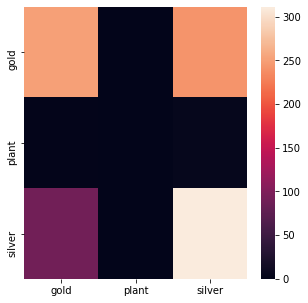

In [616]:
cm = confusion_matrix(prediction_labels, true_labels)
cm_df = pd.DataFrame(cm, columns=labels, index=labels)
plt.figure(figsize = (5,5))
sns.heatmap(cm_df)

# "Top-k" evaluation

In [617]:
k = 2
def scoring_silknow_top_n(doc, labels_ns=labels_cgr, n=k):
    return np.argsort([get_document_score(doc, labels_ns[l]) for l in sorted(labels_ns.keys())])[:-(n+1):-1]
def generate_top_predictions(corpus_preprocessed, labels_cgr):
    with mp.Pool(processes=mp.cpu_count()) as pool:
        predictions = pool.map(scoring_silknow_top_n, corpus_preprocessed)
    return predictions

In [618]:
true_labels = [mapping[l] for l in ds_materials.label.tolist()]
topk_predictions_lists = generate_top_predictions(data_preprocessed, labels_cgr)
prediction_labels_lists = [[labels[l] for l in p] for p in topk_predictions_lists]

In [619]:
topk_predictions = []

for i, gt_label in enumerate(true_labels):
    topk_predictions.append(gt_label if gt_label in prediction_labels_lists[i] else prediction_labels_lists[i][0])
print(classification_report(topk_predictions, true_labels, digits=3))

              precision    recall  f1-score   support

        gold      0.968     0.997     0.982       334
       plant      0.000     0.000     0.000         3
      silver      0.995     0.982     0.988       564

    accuracy                          0.984       901
   macro avg      0.654     0.660     0.657       901
weighted avg      0.981     0.984     0.983       901



/home/semantic/.conda/envs/ismail-transformers/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/semantic/.conda/envs/ismail-transformers/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/semantic/.conda/envs/ismail-transformers/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

In [620]:
k = 3
def scoring_silknow_top_n(doc, labels_ns=labels_cgr, n=k):
    return np.argsort([get_document_score(doc, labels_ns[l]) for l in sorted(labels_ns.keys())])[:-(n+1):-1]
def generate_top_predictions(corpus_preprocessed, labels_cgr):
    with mp.Pool(processes=mp.cpu_count()) as pool:
        predictions = pool.map(scoring_silknow_top_n, corpus_preprocessed)
    return predictions
true_labels = [mapping[l] for l in ds_materials.label.tolist()]
topk_predictions_lists = generate_top_predictions(data_preprocessed, labels_cgr)
prediction_labels_lists = [[labels[l] for l in p] for p in topk_predictions_lists]
topk_predictions = []

for i, gt_label in enumerate(true_labels):
    topk_predictions.append(gt_label if gt_label in prediction_labels_lists[i] else prediction_labels_lists[i][0])
print(classification_report(topk_predictions, true_labels, digits=3))

              precision    recall  f1-score   support

        gold      1.000     1.000     1.000       344
      silver      1.000     1.000     1.000       557

    accuracy                          1.000       901
   macro avg      1.000     1.000     1.000       901
weighted avg      1.000     1.000     1.000       901

